In [1]:
#core
import sys
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.metrics.pairwise import cosine_distances
from sklearn.model_selection import train_test_split

#geo
import geopandas as gpd
import h3pandas
from shapely.geometry import Polygon, Point, LineString, shape
from keplergl import KeplerGl

sys.path.append('../src')

import utils as gt
from enums import postgress_connection, postgress_db, lp, schema, RES, bad_hex_with_postamat

# some initial values
engine = create_engine(f'postgresql://{lp}@{postgress_connection}/{postgress_db}')

PATH = '../data'
RANDOM_STATE = 42

SCHEMA = schema
pd.set_option('display.max_columns', 200)

## Сбор данных

In [2]:
df_feats = pd.read_sql(f"select * from {SCHEMA}.platform_features", engine)

In [3]:
df_postamats = pd.read_sql(f"""
with build as  
(
 select * from postamat.platform_buildings pb 
 where purpose_name  = 'Жилой дом'
)
select pc.*
from build b
join postamat.platform_companies pc 
    on text(pc.address_building_id) = b.id
where rubric = 'Постаматы'
    and rubrics_0_name = 'Постаматы'
""", engine)
df_postamats['company'] = df_postamats['name'].str.split(',').str[0]
#фильтрация маленьких компаний
filter_companies = df_postamats.groupby('company', as_index=False)[['rubric']].count()
df_postamats = df_postamats[df_postamats['company']\
                .isin(filter_companies[filter_companies['rubric']>100]['company'].tolist())]

df_postamats.shape

(3161, 10)

In [4]:
#проходимость
df_passability = pd.read_sql(f"""SELECT geo_h3_10, cnt_morning, cnt_afternoon, cnt_evening, cnt_night
FROM {SCHEMA}.msk_pass""", engine)

In [5]:
# фичи на хексагону
df_piv = pd.pivot_table(df_feats, index = f'geo_h3_{RES}', columns = 'kind', values = df_feats.columns[2:])
df_piv.columns = df_piv.columns.to_series().str.join('_')
df_piv = pd.merge(df_piv, df_passability, how = 'left', on = f'geo_h3_{RES}')
df_piv.fillna(0, inplace=True)

In [6]:
#выбираю рандомную часть от всех постаматов, тк всего их слишком много
df_postamats, X_test = train_test_split(df_postamats, test_size=0.7, random_state=42)

In [7]:
df_postamats['geo_h3_10'].drop_duplicates().shape[0]**2

660969

In [8]:
#корреляция фичей с постаматами
df_corr = df_piv.corr()[['postamaty_walking_5min']].reset_index()
df_corr['postamaty_walking_5min'].min() #должны быть только положительные корреляции

/var/folders/3q/9304t9dj6yb6rxcr24slkv500000gn/T/ipykernel_33053/797631876.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df_piv.corr()[['postamaty_walking_5min']].reset_index()


0.03647771130908677

In [9]:
#выбираем топ 50 фичей по корреляции
df_corr = df_corr.sort_values(by='postamaty_walking_5min', ascending=False)[2:52]
MODEL_COLUMNS = df_corr['index'].tolist()

In [10]:
#На постаматы натягиваю фичи
df_data = df_postamats.merge(df_piv[['geo_h3_10']+MODEL_COLUMNS], on='geo_h3_10')
df_data.fillna(0, inplace=True)
df_data = df_data[['geo_h3_10']+MODEL_COLUMNS].drop_duplicates()
df_data['join_col'] = 1
df_data['np_array'] = df_data.apply(lambda x: 
                        np.array(x[MODEL_COLUMNS]).reshape(1,-1), axis=1)
df_data.shape

(813, 53)

In [11]:
#вариант расчета на numpy
# %%time
# x_array = np.array(df_data[[name+'_x' for name in MODEL_COLUMNS]])
# y_array = np.array(df_data[[name+'_y' for name in MODEL_COLUMNS]])
# dist_array = np.array([])

# for i in range(x_array.shape[0]):
#     np.append(dist_array, cosine_distances(x_array[i].reshape(1,-1), y_array[i].reshape(1,-1)))

In [12]:
%%time
# считаем косинусыне расстояния
df_data = df_data.merge(df_data, how='left', on='join_col')
df_data['cos_dist'] = df_data.apply(lambda x: cosine_distances(x['np_array_x'], x['np_array_y'])[0][0], axis=1)
df_data = df_data[df_data['geo_h3_10_x']!=df_data['geo_h3_10_y']].reset_index(drop=True)
df_data.shape

CPU times: user 1min 29s, sys: 4.71 s, total: 1min 33s
Wall time: 1min 36s


(660156, 106)

<AxesSubplot: >

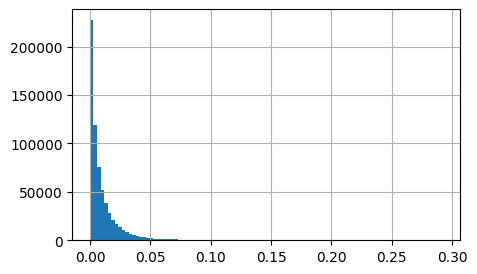

In [13]:
df_data['cos_dist'].hist(bins=100, figsize=(5,3))

<AxesSubplot: >

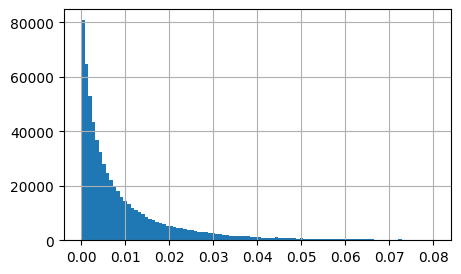

In [14]:
df_data[df_data['cos_dist']<0.08]['cos_dist'].hist(bins=100, figsize=(5,3))

In [15]:
#топ 10 хескагон
df_data_10 = df_data.sort_values(by='cos_dist', ascending=True).head(9)

In [16]:
good_hex = pd.DataFrame(pd.concat([df_data_10['geo_h3_10_x'], 
                                   df_data_10['geo_h3_10_y']]).drop_duplicates(), \
                        columns=['geo_h3_10']).reset_index(drop=True)
good_hex = good_hex.merge(df_piv[['geo_h3_10']+MODEL_COLUMNS], on='geo_h3_10')
good_hex['join_col'] = 1
good_hex['np_array'] = good_hex.apply(lambda x: 
                        np.array(x[MODEL_COLUMNS]).reshape(1,-1), axis=1)

In [17]:
good_hex.shape

(10, 53)

In [18]:
good_hex['geo_h3_10'].tolist()

['8a11aa6a469ffff',
 '8a11aa4eb48ffff',
 '8a11aa71454ffff',
 '8a11aa44c2a7fff',
 '8a11aa45371ffff',
 '8a11aa624a6ffff',
 '8a11aa61898ffff',
 '8a11aa61476ffff',
 '8a11aa702697fff',
 '8a11aa709d07fff']

In [19]:
#вся москва
df_pred_all = df_piv.reset_index()[[f'geo_h3_{RES}']+MODEL_COLUMNS]
df_pred_all['join_col'] = 1
df_pred_all['np_array'] = df_pred_all.apply(lambda x: 
                        np.array(x[MODEL_COLUMNS]).reshape(1,-1), axis=1)
df_pred_all = df_pred_all.merge(good_hex, how='left', on='join_col')
df_pred_all['cos_dist'] = df_pred_all.apply(lambda x: 
                                            cosine_distances(x['np_array_x'], x['np_array_y'])[0][0], 
                                            axis=1)
df_pred_all = gt.geo_lat_lon_from_h3(df_pred_all, f'geo_h3_{RES}_x')
df_pred_all.shape

(787570, 108)

In [20]:
df_for_map = df_pred_all.groupby(by=[f'geo_h3_{RES}_x', 'lat', 'lon'])\
        ['cos_dist'].agg(['median', 'min', 'mean']).reset_index()
df_for_map['median'] = 1 - df_for_map['median']
df_for_map['min'] = 1 - df_for_map['min']
df_for_map['mean'] = 1 - df_for_map['mean']

In [21]:
df_for_map = df_for_map.rename(columns={'geo_h3_10_x': 'geo_h3_10'})

In [22]:
df_for_map.sort_values(by='median').head()

,geo_h3_10,lat,lon,median,min,mean
6382,8a11aa000ac7fff,56.007661,37.154566,0.0,0.0,0.0
32686,8a11aa623487fff,55.842465,37.708927,0.0,0.0,0.0
32687,8a11aa62348ffff,55.843158,37.710563,0.0,0.0,0.0
24420,8a11aa5446b7fff,55.728059,37.076331,0.0,0.0,0.0
32688,8a11aa623497fff,55.841276,37.709056,0.0,0.0,0.0


<AxesSubplot: >

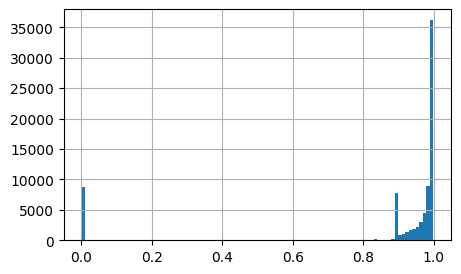

In [23]:
df_for_map['median'].hist(bins=100, figsize=(5,3))

In [24]:
df_for_map.head()

,geo_h3_10,lat,lon,median,min,mean
0,8a1181b0d827fff,55.496330,37.600208,0.890795,0.928233,0.892590
1,8a1181b0d867fff,55.498905,37.603315,0.991118,0.993494,0.989311
2,8a1181b0d907fff,55.496133,37.596840,0.923169,0.953919,0.924265
3,8a1181b0d90ffff,55.496826,37.598459,0.891679,0.928952,0.893456
4,8a1181b0d917fff,55.494944,37.596971,0.892814,0.929875,0.894569


map_ = KeplerGl(height=800)
map_.add_data(df_for_map[['lat', 'lon', 'median', 'min']], 'moscow')
map_

df_for_map.to_sql(schema=SCHEMA, name = 'vector_model_msk_predictions', 
                  con=engine, if_exists='replace', index=None)

In [25]:
df_for_map = df_for_map.rename(columns={'median': 'predictions'})
df_for_map['model_type'] = 'Векторная модель'

In [28]:
df_for_map[['geo_h3_10', 'predictions', 'model_type']]\
.to_sql(schema=SCHEMA, name = 'platform_model', con=engine, if_exists='append', index=None)

757